# Twitter Sentiment Analysis - Keyword "Recession"
### Tanmay Jain


## Introduction

Year 2022 started with hope and optimism, Covid was finally behind many people's memory, businesses reopened and resumed, people were finally able to spend money from their saving. However, things were gradually getting worse as we entered into the second quarter of 2022: Supply chain disruption caused many companies to report losses after consecutive quarters; War in Ukraine pushed gas price up; Inflation soared despite positive job market reports. These events and consecutive GDP shrinkage caused market panic in fear of a RECESSION.

In this project, we use "recession" as the keyword to analyze markets' sentiment (pessimism/optimism) on this subject, especially what people think might be the cause and effect about the potential recession.

<a id="Step A – Keyword Selection and Data Collection"></a>
## Step A – Keyword Selection and Data Collection
1.	Pick one keyword (or multiple keywords if you want) of your interests.
2.	Using the Python script, collect 10K recent tweets on the selected keyword.
3.	From the collected tweets, get the list of unique author IDs.
4.	Also collect the author information of those author IDs.


In [8]:
# library imports
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from TwitterCollector import TwitterCollector
from datetime import datetime
import json
import nltk
from collections import Counter
from textblob import TextBlob
# to ignore warning messages
# source: https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
bearerToken = r"AAAAAAAAAAAAAAAAAAAAAC98hQEAAAAAeir7YYy3ChTFBoXCdCw%2BKmkegBE%3DXNkUOn9PptBCNs4RvzP0khdGPnNyRsxDLuUflfgVtiVLtuCZtS"

# initialize a TwitterCollector instance
tc = TwitterCollector(bearer_token = bearerToken)

In [1]:
#(putting "#" for safety measure)
# tweets containing the word 'recession'
query1 = 'recession -is:retweet lang:en'  

# store recent tweets based on query
recent_tweets_oct5 = tc.fetch_recent_tweets(query = query1  # specify the search query
                                            , tweets_cnt = 10000  # specify the number of tweets you want to collect
                                             , save_result = True  # if True, the tweets will be automatically saved to a json file apart from the value returned
                                            )

In [12]:
# import json for analysis
f = open('recent_post_recession -is-retweet lang-en_10000_old.json')
recent_tweets = json.load(f)

In [13]:
# save all unique author Ids 
author_ids = []

for i in range(len(recent_tweets['tweets'])):
    author_ids.append(recent_tweets['tweets'][i]['author_id'])

print(len(author_ids))

# check and remove duplicates from author list if any
author_ids = [*set(author_ids)]
print(len(author_ids))

10000
7714


In [ ]:
# get unique author info from IDs
# initialize a TwitterCollector instance
tc = TwitterCollector(bearer_token = bearerToken)
tc_other = TwitterCollector(bearer_token = r'AAAAAAAAAAAAAAAAAAAAAEaAhAEAAAAAodQksDiNX3gdVgcuFKWo9ynOYFY%3DER3a2Qs65QlW09xqAImjWcv0YzvYA4V8fMCft0SucGjrSjp7bF')
tc_another = TwitterCollector(bearer_token = r'AAAAAAAAAAAAAAAAAAAAAH18hQEAAAAAj%2FpytngG8GtAdqgGF21LqdUiUZI%3Dw56eJ1vaXlxAAwV7mdxeAEcGabdLAph24gsEBH0zpociZfkkRB')

import time
author_info = []
for a_id in range(4734, len(author_ids)): 
    try:    
        author_info.append(tc.fetch_author_info(author_ids[a_id]))
    except tweepy.TooManyRequests:
        try:
            author_info.append(tc_other.fetch_author_info(author_ids[a_id]))
        except tweepy.TooManyRequests:
            try:
                author_info.append(tc_another.fetch_author_info(author_ids[a_id]))
            except tweepy.TooManyRequests:
                print(a_id)
                print('TooManyRequests')
                time.sleep(900)

In [ ]:
# check for any none values and remove
res_author_info = [i for i in new_author_info if i is not None]

# convert author info to dataframe and create a local json copy
df_author_info = pd.DataFrame(res_author_info)
df_author_info.to_json('author_info.json')

In [5]:
#read back the json and display first two rows
df_author = pd.read_json('author_info.json')
df_author.head(2)

,created_at,name,location,public_metrics,username,description,verified,id,withheld
0,2012-03-15 11:45:15+00:00,Guddu | Levitating.nft,India,"{'followers_count': 6, 'following_count': 18, ...",Queenfreedom77,Hallucinating with my starlight @dualipa @Oliv...,False,525295114,None
1,2013-02-20 00:10:58+00:00,PSF Rwanda,Kigali/Rwanda,"{'followers_count': 48939, 'following_count': ...",PSF_Rwanda,Private Sector Federation; A professional orga...,False,1199054702,None



## Step B – Preliminary Analysis
### Procedures Performed

In [14]:
# compile all tweets into a list using 'text'
tweets_ls = []
for i in range(len(recent_tweets['tweets'])):
    tweets_ls.append(recent_tweets['tweets'][i]['text'])
    
# store all words from tweets into list
def split_list(sentence):
    result=[]
    for s in sentence:
        result.extend(s.split())
    return result

words = split_list(tweets_ls)

# add as check total
print(len(words))

272215


In [9]:
# word frequency - 10 most common with stopwords
c = Counter(words)
c.most_common(10)

[('the', 9750),
 ('a', 6568),
 ('in', 5560),
 ('to', 5195),
 ('recession', 4688),
 ('and', 4453),
 ('of', 4051),
 ('is', 4036),
 ('are', 2203),
 ('for', 2101)]

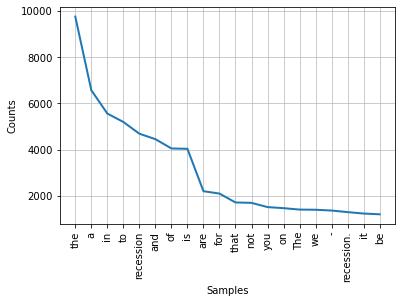

In [10]:
# plotting word frequency
%matplotlib inline 

# get frequent words
freq = nltk.FreqDist(words)
freq.plot(20);

### Text Clean Up
This is done to remove all (typical & otherwise) stopwords and retain words that have relevance for the analysis. This is performed through processes to create a final logic. 

In [12]:
# import libaries and prep for data clean up
import pickle
import string
with open('stopwords.pkl', 'rb') as f:
    stopwords = pickle.load(f)

In [13]:
print(len(words))
words2 = [w for w in words if w not in stopwords and len(w) > 1]
print(len(words2))

puncs = string.punctuation
dgts = string.digits
for s in ['@','#','%','\'','-']:
    puncs=puncs.replace(s,'')
    
table_p = str.maketrans(puncs, len(puncs) * " ")
words_punc = [s.translate(table_p) for s in words2]
words_punc_lower = [s.strip().lower() for s in words_punc] # removing trailing white spaces and converting to lowercase

# removing https words
final_words = [ i for i in words_punc_lower if 'https' not in i ]
print(len(final_words))

# again remove stopwords if any
stopwords.extend(['amp','it’s','get','last','going','still','would','could','like','one','even',\
                  'know','go','see','yet','say','look'])
final_words = [w for w in final_words if w not in stopwords and len(w) > 1]
print(len(final_words))

272215
180019
<class 'dict'>
174768
154840


In [14]:
# 10 most common without stopwords
c = Counter(final_words)
c.most_common(10)

[('recession', 9032),
 ('inflation', 1454),
 ('economy', 1146),
 ('us', 933),
 ('uk', 791),
 ('#recession', 685),
 ('global', 648),
 ('market', 611),
 ('rates', 554),
 ('growth', 539)]

In [15]:
# 10 most popular hashtags ("#")
Counter([x for x in final_words if "#" in x]).most_common(10)

[('#recession', 685),
 ('#inflation', 192),
 ('#economy', 118),
 ('#layoffs', 99),
 ('#layoff', 96),
 ('#jobs', 91),
 ('#thelayoff', 85),
 ('#stockmarket', 74),
 ('#whitecollarjobs', 70),
 ('#stocks', 69)]

In [16]:
# 10 most popular name mentions ("@")
Counter([x for x in final_words if "@" in x]).most_common(10)

[('@bbcnews', 121),
 ('@tvkev', 113),
 ('@potus', 105),
 ('@ctvnews', 76),
 ('@unusual whales', 62),
 ('@bren4bassetlaw', 56),
 ('@trussliz', 55),
 ('@skynews', 52),
 ('@thedemocrats', 45),
 ('@youtube', 40)]

In [17]:
# three most sources of tweets
source=[]
for s in recent_tweets['tweets']:
    source.append(s['source'])

Counter(source).most_common(3)

[('Twitter Web App', 2931),
 ('Twitter for iPhone', 2859),
 ('Twitter for Android', 1937)]

In [18]:
# create dataframe of tweets to prep for the time series plot
tweets_df=pd.DataFrame.from_dict(recent_tweets['tweets'])
tweets_df.head(1) # show one row as example

,author_id,id,source,public_metrics,lang,created_at,edit_history_tweet_ids,text,possibly_sensitive,entities,context_annotations,in_reply_to_user_id,referenced_tweets,attachments,geo,withheld
0,3040830976,1576002702332469250,Twitter for iPhone,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",en,2022-10-01T00:14:59.000Z,[1576002702332469250],"BoE, ECB, Fed, China, Japan markets all on lif...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# splitting time stamp into dates and hours
tweets_df['date'] = tweets_df['created_at'].str[0:10]
tweets_df['hour'] = tweets_df['created_at'].str[11:13]

In [20]:
# group tweets by hour
df_time_series = tweets_df.groupby(['hour'])['text'].count().reset_index()

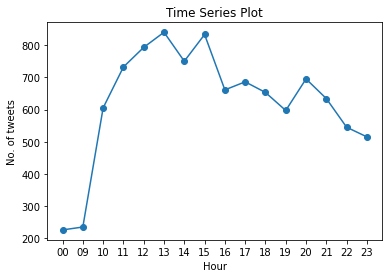

In [21]:
# create time series plot
plt.plot( df_time_series["hour"], df_time_series["text"], marker='o')

# Labelling 
plt.xlabel("Hour")
plt.ylabel("No. of tweets")
plt.title("Time Series Plot")

# Display
plt.show()

In [ ]:
# we define the most influencial tweet by ..... write more to finish
# question: don't know why it is given such output
tweets_df['influence_score'] = None

for i in range(0,len(tweets_df)):
    tweets_df['influence_score'][i] = tweets_df['public_metrics'][i]['retweet_count'] + tweets_df['public_metrics'][i]['reply_count'] + tweets_df['public_metrics'][i]['like_count'] + tweets_df['public_metrics'][i]['quote_count']

In [23]:
# printing the three most influencial tweets
print(tweets_df.sort_values('influence_score',ascending=False).head(3)['text'])

9719    So the pound has come back stronger than it wa...
6047    Joe Biden has brought us a recession, and now ...
8224    Record inflation. Endless spending. Economy in...
Name: text, dtype: object


In [26]:
# Who are the three most vocal authors on the keyword? In other words, who are the most frequently tweeting authors in the tweet data?  
most_vocal_authors=tweets_df['author_id'].value_counts()[:3].index.tolist()
print(most_vocal_authors)
most_vocal_authors=[int(item) for item in most_vocal_authors]
print(df_author[df_author['id'].isin(most_vocal_authors)][['id','username']].reset_index(drop=True))

['1488699517914345474', '1564880490548498432', '990208711']
                    id      username
0  1564880490548498432  TheLayoffBot
1            990208711    equalearth


In [27]:
#getting info for the remaining one separately
tc.fetch_author_info('1488699517914345474')['username']

'StockIlluminat1'

In [30]:
# suppressing SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# identifing the three most influencial authors
df_author['user_score'] = None

for i in range(0,len(df_author)):
    df_author['user_score'][i] = df_author['public_metrics'][i]['followers_count'] + df_author['public_metrics'][i]['following_count'] + df_author['public_metrics'][i]['listed_count'] + df_author['public_metrics'][i]['tweet_count']

df_author.sort_values('user_score',ascending=False).head(3)['username'].values.tolist()

['CNN', 'Reuters', 'washingtonpost']

## Step C – Word Cloud

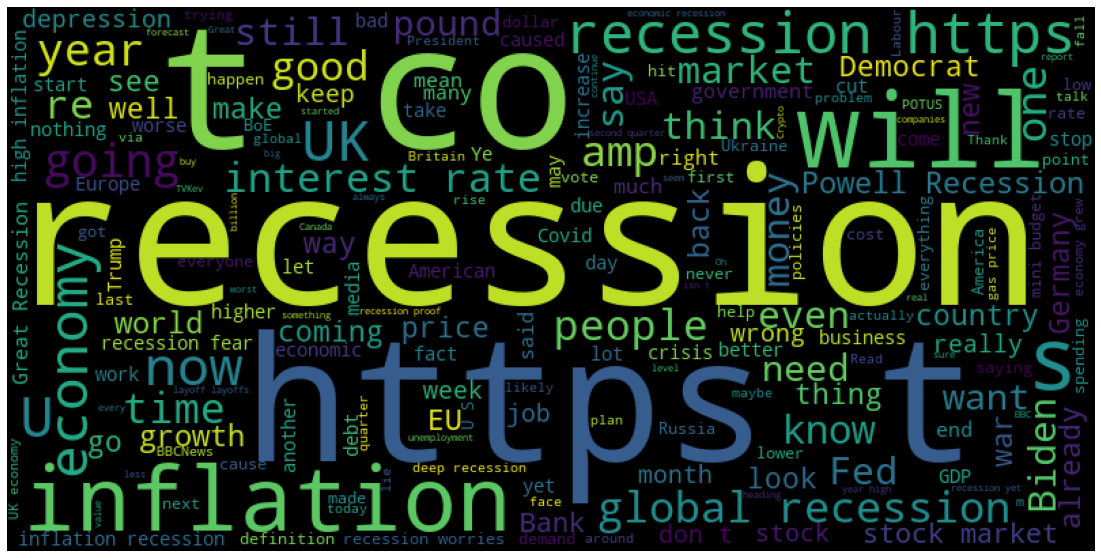

In [32]:
# Preparing wordcloud text string for visualization
wordcloud = WordCloud(width=800, height=400).generate(' '.join(words)) # note that text is a string, not a list

# Display the generated image:
plt.figure(figsize=(20,10)) # set up figure size
plt.imshow(wordcloud) # word cloud image show
plt.axis("off") # turn on axis
plt.savefig('my_word_cloud.png') # save as PNG file
plt.savefig('my_word_cloud.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook

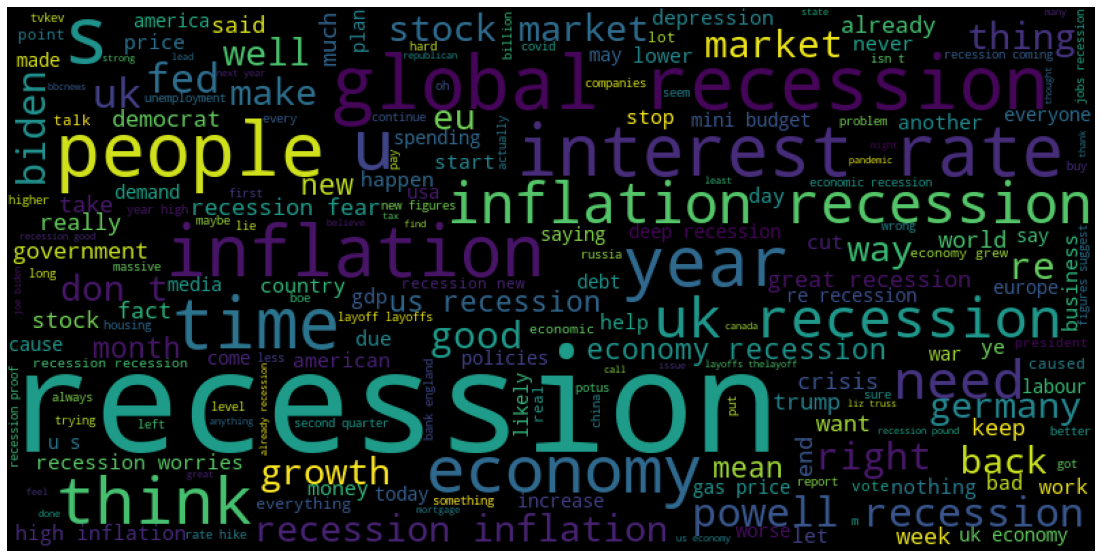

In [33]:
# Preparing wordcloud text string for visualization
wordcloud = WordCloud(width=800, height=400).generate(' '.join(final_words)) # note that text is a string, not a list

# Display the generated image:
plt.figure(figsize=(20,10)) # set up figure size
plt.imshow(wordcloud) # word cloud image show
plt.axis("off") # turn on axis
plt.savefig('my_word_cloud.png') # save as PNG file
plt.savefig('my_word_cloud.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook

In [34]:
# Removing keyword "recession" to show alternative word cloud
print(len(final_words))
stopwords.extend([i for i in final_words if 'recession' in i])
# again remove stopwords if any
final_words_without_rec = []
final_words_without_rec = [w for w in final_words if w not in stopwords and len(w) >= 1]
print(len(final_words_without_rec))

154840
144563


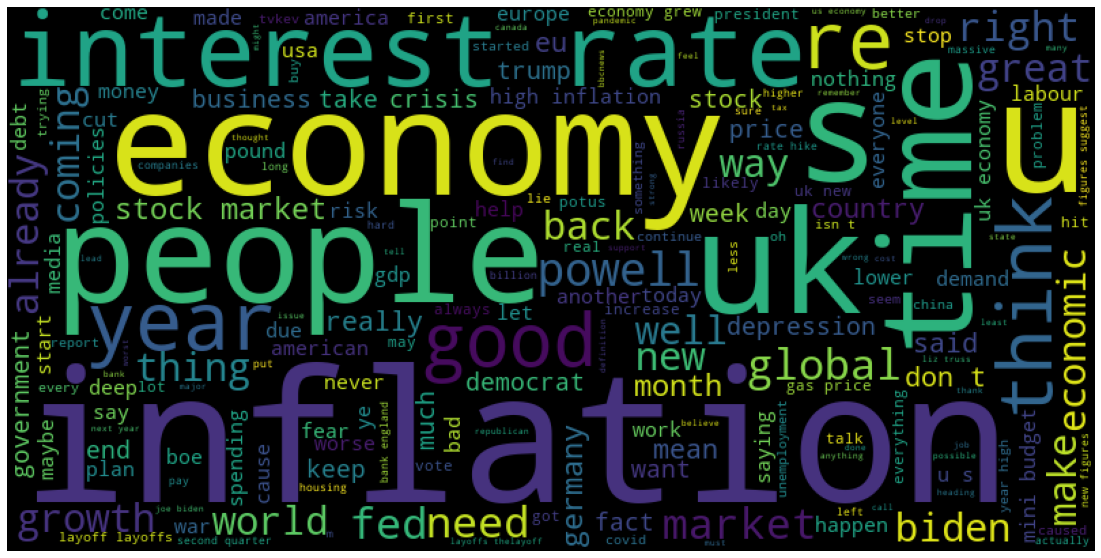

In [35]:
# Plot alternative word cloud
wordcloud = WordCloud(width=800, height=400).generate(' '.join(final_words_without_rec)) # note that text is a string, not a list

# Display the generated image:
plt.figure(figsize=(20,10)) # set up figure size
plt.imshow(wordcloud) # word cloud image show
plt.axis("off") # turn on axis
plt.savefig('my_word_cloud.png') # save as PNG file
plt.savefig('my_word_cloud.pdf') # save as PDF file
plt.show()  # show in Jupyter notebook

## Step D – Sentiment Analysis

In [37]:
# Run an sentiment analysis on each of the tweet
sub_list = []
pol_list = []

for s in tweets_df['text']:
    tb = TextBlob(str(s))
    sub_list.append(tb.sentiment.subjectivity)
    pol_list.append(tb.sentiment.polarity)

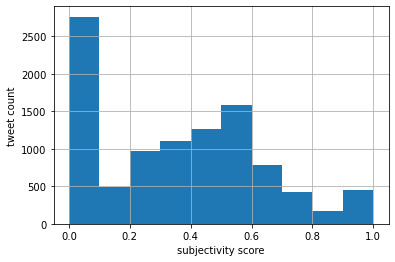

In [38]:
# Plotting the subjectivity score results in a histogram
plt.hist(sub_list, bins=10) #, normed=1, alpha=0.75)

plt.xlabel('subjectivity score')
plt.ylabel('tweet count')
plt.grid(True)
plt.savefig('subjectivity.pdf')
plt.show()

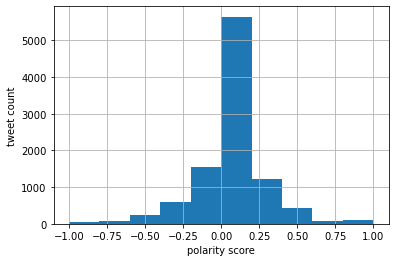

In [39]:
# Plotting the polarity score results in a histogram
plt.hist(pol_list, bins=10) #, normed=1, alpha=0.75)

plt.xlabel('polarity score')
plt.ylabel('tweet count')
plt.grid(True)
plt.savefig('polarity.pdf')
plt.show()

In [40]:
# Calculate average subjectivity
average_subjectivity=sum(sub_list)/len(sub_list); average_subjectivity

0.3522262183680474

In [41]:
# Calculate average polarity
average_polarity=sum(pol_list)/len(pol_list); average_polarity

0.04587603470013505

In [42]:
# add
tweets_df_analysis = tweets_df[['author_id','text','influence_score']]
list1  = list (zip(sub_list, pol_list))
df_temp = pd.DataFrame(list1, columns = ['sub_list', 'pol_list'])
result = pd.concat([tweets_df_analysis,df_temp],axis=1)

result

,author_id,text,influence_score,sub_list,pol_list
0,3040830976,"BoE, ECB, Fed, China, Japan markets all on lif...",0,0.000000,0.000000
1,47459808,As we move out of a pandemic and face the very...,0,0.528333,-0.036667
2,1072907762588360704,@Adam59724986 @terrystuckshop @Garynjordan @Me...,0,0.100000,0.000000
3,1010566174646657025,@CyntHarp @Gargi_Chaudhuri @iShares GDP is dow...,0,0.279167,-0.179167
4,1500062770447978501,@DeniWolff @TimRyan Meanwhile Recession loomin...,0,0.633333,-0.300000
...,...,...,...,...,...
9995,99824481,Strong UK economic data across the board today...,0,0.733333,-0.041667
9996,1351425824646434816,"@GBNEWS well, this went well for Mellor..in am...",4,0.900000,-0.500000
9997,850923103462899712,"UK not in recession, new figures suggest https...",0,0.454545,0.136364
9998,293364064,I don’t think CIMB closing their branches is a...,2,0.546875,0.171875


In [43]:
# sort and identify the top 3 most positive tweets
max_polarity = result[result['pol_list'] == result['pol_list'].max()]
max_polarity_top_3=max_polarity.sort_values('influence_score',ascending=False)[:3].reset_index()

max_polarity_top_3

,index,author_id,text,influence_score,sub_list,pol_list
0,2416,933120630563545089,How do you hedge yourself against what's happe...,8,0.3,1.0
1,6713,1526186275354574850,@michaeljburry @POTUS the perfect president fo...,6,1.0,1.0
2,2893,1246507636079484929,@CTVNews 2033 will be wonderful. Recession and...,5,1.0,1.0


In [44]:
# most "positive" tweet 1
max_polarity_top_3['text'][0]

"How do you hedge yourself against what's happening and what's about to happen?\n\nInflation, recession, Ukraine, Vietnam,...\n\nWhat are you putting your money into? What is going to be the best store hold of value? https://t.co/8awybYNjK2"

In [45]:
# most "positive" tweet 2
max_polarity_top_3['text'][1]

'@michaeljburry @POTUS the perfect president for a recession'

In [46]:
# most "positive" tweet 3
max_polarity_top_3['text'][2]

'@CTVNews 2033 will be wonderful. Recession and a socialist government hell bent on raising taxes… can’t wait.'

In [47]:
# sort and identify the top 3 most negative tweets
min_polarity=result[result['pol_list'] == result['pol_list'].min()]
min_polarity_top_3=min_polarity.sort_values('influence_score',ascending=False)[:3].reset_index()

In [48]:
# most "negative" tweet 1
min_polarity_top_3['text'][0]

'🚨BREAKING NEWS 🚨\n\n⬇️ The DOW shed 9% in a MONTH\n\n📉 The WORST month since March 2020\n\n❌ The economy is NOT growing.  \n\n➡️ The economy is in a RECESSION\n\nSchumer Lied.  Biden Lied.\n\nAnd WE are paying the price #FireThem \n\nhttps://t.co/lge3YNhHZO'

In [49]:
# most "negative" tweet 2
min_polarity_top_3['text'][1]

"Thank you Janet. With US in recession, the EU in crisis, there's one issue the #UKmedia REFUSE to face. #Lockdowns caused this, and they were the biggest driver of them &amp; suppressor of opposition. The media are an evil beast that can't bear to look in the mirror #DefundTheBBC https://t.co/rnlm8h3YB0"

In [50]:
# most "negative" tweet 3
min_polarity_top_3['text'][2]

'S&amp;P 500 falls 9.3% in worst monthly drop since march 2020.\n#recession \n#NASDAQ100'

### Extra Analysis - Emoji

In [22]:
#process and preserve emoji only
import string

emoji = []
for i in words:
    a = i.lower()
    emoji.extend(a)

    
print(len(emoji))
print(len(set(emoji)))

printable0 = string.printable
printable = printable0 + '’' + '‘' + '“' + '”' + '…' + '️' + '—' + '•' + '–' + '🇧' + '🇬' + '£' + '♂' + '🏻' + '€' + '🇺' + '♀'

emoji1 = []
for i in emoji:
    if i not in printable:
        emoji1.append(i)

# Count Unique emojis for checks

print(len(emoji1))
print(len(set(emoji1)))
print(emoji1)


1514644
462
2410
379
['🇸', '🤣', '）', '📍', '🗣', '👍', '⛈', '👉', '🥴', '😂', '😂', '😂', 'ï', '👉', '🐦', '\U0001faf6', '🌎', '⚠', '⬇', '😵', '\u200d', '💫', '😂', '🍻', '😡', '😂', '😂', '😂', '😂', '😂', '😂', '😵', '̗', '🎆', '😎', '😎', '😂', '😂', '😂', '🤣', '🤣', '🤣', '🤣', '🙄', '🥴', '🇦', '😯', '😯', '😢', '😯', '😩', '😰', '📉', '🤦', '\u200d', '\u2066', '\u2069', '\u2066', '\u2069', '😂', '😂', '🤣', '☏', '🤣', '😝', '🤡', '💰', '➡', '🤡', '💣', '👉', '🔥', '🎶', '\U0001f979', '\U0001fae1', '😏', '👍', '🤣', '🤣', '🤔', '🤣', '🤣', '🤣', '🤔', '🤣', '🤣', '🤣', '🤣', '🤣', '🤣', '🤔', '🤣', '🤣', '💰', '🥰', '😳', '👍', '😊', '🔫', '🤦', '\u200d', '😝', '🤦', '😂', '😂', '😂', '😂', '😂', '😂', '🤝', '🤣', '😉', '📝', '✅', '✅', '🎧', '📉', '📉', '📉', '📉', '✌', '🏼', '🪙', '🤣', '🤣', '🤣', '🤣', '🤣', '🤣', '🤣', '🤯', '😃', '🚩', '🤦', '\u200d', '💪', '🏼', '🏆', '📉', '🤣', '😂', '\u2066', '\u2069', '😔', '😂', '👍', '😂', '😫', '😂', '🔥', '🔥', '🔥', '😂', '😂', '\u2066', '\u2069', '🤦', '\u200d', '👀', '🤮', '👎', '🙈', '🤦', '\u200d', '😂', '😂', '😂', '🤡', '🤡', '🤡', '😄', '😂', '😂', '🤣', '📉', '🤡', '

In [17]:
# Count Top 10 Most mentioned Emojis
from collections import Counter

c = Counter(emoji1)
c.most_common(20)

[('📉', 215),
 ('😂', 206),
 ('🤣', 140),
 ('📈', 108),
 ('\u200d', 101),
 ('🤡', 78),
 ('🤦', 56),
 ('🤷', 54),
 ('🙄', 53),
 ('🤔', 49),
 ('👇', 40),
 ('👉', 36),
 ('👍', 28),
 ('🚀', 28),
 ('✅', 27),
 ('\u2066', 26),
 ('🔥', 24),
 ('🚨', 23),
 ('\u2069', 22),
 ('💩', 20)]